# Notebook Version 2

I made a condensed, and more flexible notebook from out initial. It contains the same processing, but not ass much intermittent reporting making navigation easier. One can of course add code where additional summary reports or graphics is needed. In addition, if the functions generating these reports are in a separate file, this notebook can stay condensed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import dataframe_image as dfi

In [2]:
from helpers import outliers_IQR, outliers_z_score, outliers_min_max, handle_outliers, fix_obesity

In [3]:
np.random.seed(2023)

# 2. Data Analysis and Processing

In [4]:
diabetes = pd.read_csv('diabetes.csv')

binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                   'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                   'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']
one_hot_features = {} # for future use

print("Found:", len(cat_features+binary_features+num_features)+1) # +1 for Gender
print("In DS:", diabetes.shape[1]-1) # -1 for target


Found: 23
In DS: 23


## Initial Data Analysis

### Questions

Code uses for answering questions in this section

In [5]:
# number of entries
print("Rows: ", diabetes.shape[0], ", Columns:", diabetes.shape[1])
print("---------------------------------------------------")

# What type of values do you have?
diabetes.info()
print("---------------------------------------------------")

# Missing data
print("Percentage of missing data:", diabetes.isna().mean().mean())
print("---------------------------------------------------")

# Duplicates
print("Number of duplicates:", diabetes[diabetes.duplicated(keep=False)].shape[0]/2)
print("---------------------------------------------------")

Rows:  546 , Columns: 24
---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 534 non-null    float64
 1   Gender              542 non-null    object 
 2   Race                537 non-null    object 
 3   Occupation          534 non-null    object 
 4   GP                  539 non-null    object 
 5   Height              538 non-null    float64
 6   Weight              541 non-null    float64
 7   Obesity             538 non-null    object 
 8   Temperature         546 non-null    float64
 9   Urination           532 non-null    float64
 10  TCep                546 non-null    object 
 11  Polydipsia          540 non-null    object 
 12  Sudden Weight Loss  530 non-null    object 
 13  Weakness            541 non-null    object 
 14  Polyphagia          544 non-n

### Interesting findings - Bias in the data set

In [6]:
# There are some interesting things to see in the categoricals ...
# Only one Black in entire data set ...
# This looks very much like a rich person data set ...
for c in ['Race', 'Occupation']:
  print(diabetes.groupby(c, dropna=False).size())

Race
Asian     10
Black      1
White    526
NaN        9
dtype: int64
Occupation
Architect        41
Consultant       41
Dentist          39
Economist        38
Engineer         28
Entrepreneur     31
Journalist       30
Judge            46
Lawyer           32
Manager          52
Retired         155
Student           1
NaN              12
dtype: int64


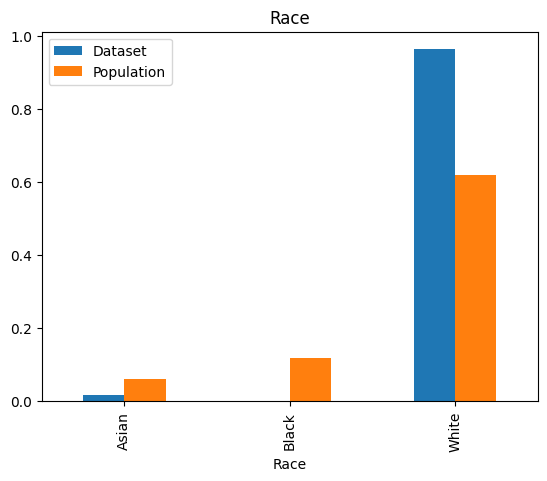

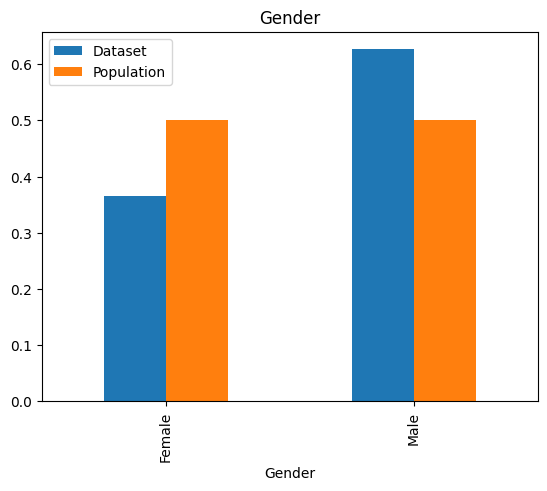

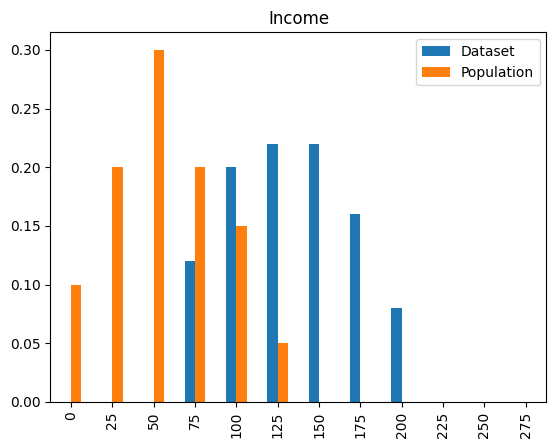

In [7]:
# Race
#https://en.wikipedia.org/wiki/United_States
demo_race = pd.Series([.62, .12, .06, 2], index=['White', 'Black', 'Asian', 'Mixed/Other'])
diabetes_race = pd.DataFrame(diabetes.groupby('Race').size(), columns = ['Dataset'])/diabetes.shape[0]
diabetes_race = diabetes_race.join(pd.DataFrame(demo_race, columns = ['Population']))
diabetes_race.plot.bar()
plt.title("Race")
plt.savefig("images/diabetes_race.png")

# Gender
demo_gender = pd.Series([.5, .5], index=['Male', 'Female'])
diabetes_gender = pd.DataFrame(diabetes.groupby('Gender').size(), columns = ['Dataset'])/diabetes.shape[0]
diabetes_gender = diabetes_gender.join(pd.DataFrame(demo_gender, columns = ['Population']))
diabetes_gender.plot.bar()
plt.title("Gender")
plt.savefig("images/diabetes_gender.png")

# Income
income_classes = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
pop_income = pd.DataFrame(pd.Series([0.1, 0.2, 0.3, 0.2, 0.15, 0.05, 0, 0, 0, 0, 0, 0], index=income_classes), columns = ['Population'])
ds_income = pd.DataFrame(pd.Series([0, 0, 0, 0.12, 0.2, 0.22, 0.22, 0.16, 0.08, 0, 0, 0], index=income_classes), columns = ['Dataset'])
ds_income = ds_income.join(pop_income) 
ds_income.plot.bar()
plt.title("Income")
plt.savefig("images/diabetes_income.png")

# Age
#diabetes['Age'].plot.hist(bins=20)

### Missing data - Part 1

#### Analyze

In [9]:
missing_data_stats = pd.DataFrame(diabetes.isna().sum().sort_values(ascending=False), columns=['Count'])
missing_data_stats2 = pd.DataFrame(diabetes.isna().mean().sort_values(ascending=False)*100, columns=['Percentage'])
missing_data_stats = missing_data_stats.join(missing_data_stats2)

print("Total number of missing data:", diabetes.isna().sum().sum())
print("Percentage of missing data:", diabetes.isna().mean().mean())
print("Samples with at least one missing value:", len(diabetes[diabetes.isnull().any(axis=1)]))
print("Percentage samples with at least one missing value:", len(diabetes[diabetes.isnull().any(axis=1)])/len(diabetes))

# How many values are the samples missing
i = 1
nomis = diabetes[diabetes.isna().sum(axis=1) == i].shape[0]
while nomis > 0:
    print(f"Number of samples with {i} missing values: {nomis}")
    i += 1
    nomis = diabetes[diabetes.isna().sum(axis=1) == i].shape[0]


dfi.export(missing_data_stats.round({'Count': 0, 'Percentage': 2}), 'images/missing_data.png')

Total number of missing data: 176
Percentage of missing data: 0.01343101343101343
Samples with at least one missing value: 151
Percentage samples with at least one missing value: 0.2765567765567766
Number of samples with 1 missing values: 128
Number of samples with 2 missing values: 21
Number of samples with 3 missing values: 2


### Data Cleaning

#### Uniform formatting

In [9]:

# Converts all binary features to lower case
for f in binary_features:
   diabetes[f] = diabetes[f].str.lower()

# Converts all binary features to ints, preserving Na-s
diabetes = diabetes.replace({'yes':1, 'no':0}) 
diabetes = diabetes.replace({'Positive':1, 'Negative':0})

#### Duplicates

We delete them. We assume they are caused by an error in the data collection, and it's unlikely that there are two correct instances with the exact same values.  

In [10]:
diabetes = diabetes.drop_duplicates(keep='first')

#### Meters to centimeters

In [11]:
# Converts meter to centimeter
condition = diabetes['Height'] < 100
diabetes.loc[condition, ['Height']] = diabetes.loc[condition, ['Height']].mul(100)

#### Dropping females

In [12]:
diabetes = diabetes[diabetes['Gender'] == 'Male']

## Train - Test split
We split as early as possible to avoid cross contamination of information from the test set.

### Missing categorical data
If we don't fill missing categorical data now, we run the risk that either the train or the test set don't contain any NA-s. This can cause a difference in columns after one hot encoding and lead to a crash.

In [13]:
# we want to fill early s.t. there are no Na-s beyond this point
diabetes[cat_features + ['Gender']] = diabetes[cat_features+ ['Gender']].fillna('MISSING')

### Splitting

In [14]:
train_proportion = 0.8
train_idx = np.random.choice(diabetes.index, int(train_proportion*len(diabetes.index)), replace=False)
train = diabetes.loc[train_idx]
test = diabetes.drop(train_idx)
assert len(diabetes.index) == len(train.index) + len(test.index)

## Outliers

### Univariate

In [15]:
train[num_features].describe().loc[['min','max']]

,Age,Height,Weight,Temperature,Urination
min,25.0,154.01,47.85,36.45,0.83
max,377.0,194.24,125.95,37.43,12.00


#### Identify

##### Thresholds

In [16]:
# Init with domain knowledge
train_outlier_bounds = pd.DataFrame(
    {'Lower': [0, 110, 0, np.nan, np.nan],
     'Upper': [120, 240, 200, np.nan, np.nan]},
     index=num_features
)


# Statistical
for f in ['Temperature', 'Urination']:
    l_IQR, u_IQR = outliers_IQR(train, f)
    l_Z, u_Z = outliers_z_score(train, f)
    train_outlier_bounds.loc[f] = [max(min(l_IQR, l_Z),0), max(u_IQR, u_Z)]

train_outlier_bounds

,Lower,Upper
Age,0.000000,120.000000
Height,110.000000,240.000000
Weight,0.000000,200.000000
Temperature,36.386796,37.603750
Urination,0.000000,4.904812


##### Extent in our data set

In [17]:
pd.concat(
    [outliers_min_max(train, 'Age', train_outlier_bounds.loc['Age', 'Lower'], train_outlier_bounds.loc['Age', 'Upper']),
    outliers_min_max(train, 'Urination', train_outlier_bounds.loc['Urination', 'Lower'], train_outlier_bounds.loc['Urination', 'Upper'])]
)

,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
137,155.0,Male,White,Judge,Dr. Mayson Harris,167.12,65.05,0.0,36.99,1.58,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
449,377.0,Male,White,Consultant,Dr. Angharad Grainger,169.31,68.32,0.0,37.23,1.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
138,39.0,Male,White,Lawyer,Dr. Ingrid Mata,174.51,83.65,0.0,37.19,12.00,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1


I put the box plots back in, if we want to skip the step of "using visual tools", thats fine. We can just remove them again.

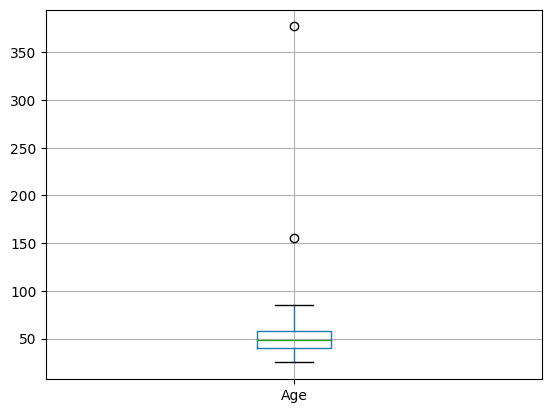

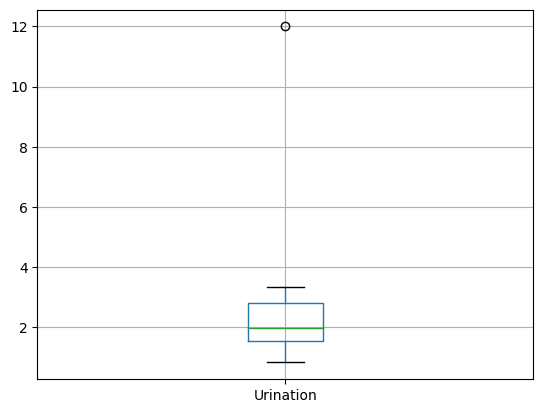

In [18]:
for f in ['Age', 'Urination']:
    bp = train.boxplot(f)
    bp.plot()
    plt.savefig('images/bp_'+f+'.png') 
    plt.show()

#### Deal with

In [19]:
train = handle_outliers(train, train_outlier_bounds)
test = handle_outliers(test, train_outlier_bounds)

# How does it look now? All min max values sensible ...
train[num_features].describe().loc[['min','max']]

,Age,Height,Weight,Temperature,Urination
min,25.0,154.01,47.85,36.45,0.83
max,85.0,194.24,125.95,37.43,3.34


### Combined outliers

Combined outliers must be handled after fixing the individual ones, otherwise the same ones would be discovered

C:\Users\andre\Dropbox\IN-STK5000\H23\project\IN-STK5000-9000-Project-1\helpers.py:132: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df[features].fillna(df.mean())


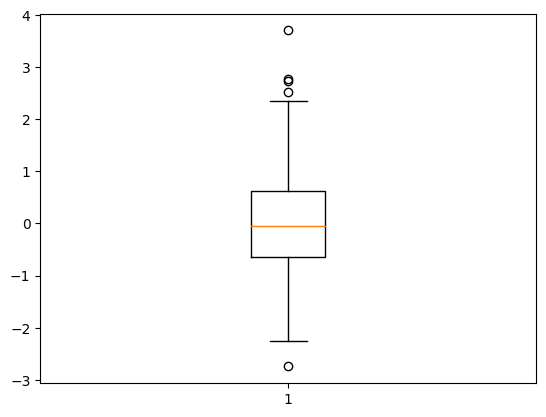

In [20]:
from helpers import combined_outliers
import scipy.stats as stats

zs = combined_outliers(train, num_features)
train[abs(zs) > 3 ] # find rows with z-score outside [-3,3]
plt.boxplot(zs)
plt.show()


Quantile - Quantile to test for normality, which the z-s passes

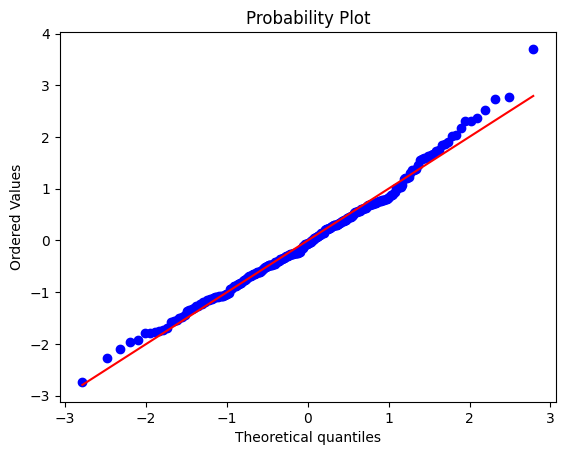

In [21]:
stats.probplot(zs, dist="norm", plot=plt)
plt.show()

## Missing data - Part 2

### Deal with

#### Derived Features

In [22]:
train = fix_obesity(train)
test = fix_obesity(test)

#### Missing Binaries

In [23]:
train[binary_features] = train[binary_features].fillna(0)
test[binary_features] = test[binary_features].fillna(0)

#### Missing numeric

In [24]:
# Fill Na-s with mean. 
train[num_features] = train[num_features].fillna(train[num_features].mean())
# We fill the test data with the mean of the train data, making the test set indepentent of each others
test[num_features] = test[num_features].fillna(train[num_features].mean())

#### Testing for remaining Na-s

In [25]:
assert train.isna().sum().sum() == 0, f'train data still containts {train.isna().sum().sum()} Na-s'
assert test.isna().sum().sum() == 0, f'test data still containts {test.isna().sum().sum()} Na-s'

Henceforth, we may assume both train and test data contains no Na-s, drastically simplifying the rest of the code. For online learning, we should perhaps implement the code in this section as a function so that we can apply it on new cases continuously.

## Encoding

In [26]:
gender_dummies_train = pd.get_dummies(train['Gender'], prefix='gender')
train = train.join(gender_dummies_train)

gender_dummies_test = pd.get_dummies(test['Gender'], prefix='gender')

test = test.join(gender_dummies_test)

one_hot_features['Gender'] = list(set(list(gender_dummies_train.columns) + list(gender_dummies_test.columns)))

In [27]:
# Add one hot variable column to train/test if it exists for one, but not the other adn fill with 0
for i in list(gender_dummies_train):
    if i not in gender_dummies_test:
        test[i] = 0

for i in list(gender_dummies_test):
    if i not in gender_dummies_train:
        train[i] = 0

In [28]:
def checkEqualColumns(L1, L2):
    return len(L1) == len(L2) and sorted(L1) == sorted(L2)

In [29]:
assert checkEqualColumns(train.columns, test.columns), f'train and test set doesent have the same features'

In [30]:
for i in zip(sorted(train.columns), sorted(test.columns)):
    print(i)

('Age', 'Age')
('Alopecia', 'Alopecia')
('Delayed Healing', 'Delayed Healing')
('Diabetes', 'Diabetes')
('GP', 'GP')
('Gender', 'Gender')
('Genital Thrush', 'Genital Thrush')
('Height', 'Height')
('Irritability', 'Irritability')
('Itching', 'Itching')
('Muscle Stiffness', 'Muscle Stiffness')
('Obesity', 'Obesity')
('Occupation', 'Occupation')
('Partial Paresis', 'Partial Paresis')
('Polydipsia', 'Polydipsia')
('Polyphagia', 'Polyphagia')
('Race', 'Race')
('Sudden Weight Loss', 'Sudden Weight Loss')
('TCep', 'TCep')
('Temperature', 'Temperature')
('Urination', 'Urination')
('Visual Blurring', 'Visual Blurring')
('Weakness', 'Weakness')
('Weight', 'Weight')
('gender_Male', 'gender_Male')


## Correlations

In [31]:
corr = train.corr(numeric_only=True)
#corr['Diabetes']
#sns.heatmap(corr)

# look at the smallest and largest in absolute value
cmap = 'coolwarm' # Added colour map as a variable for consistent plot style
corrs = corr.stack().loc[lambda x : (x < 1)].abs().sort_values()
print("Smallest:")
print(corrs[:20])
print("-------------------------------")
print("Largest:")
print(corrs[-20:])
corr.style.background_gradient(cmap=cmap).set_precision(2)
plt.savefig('images/cont_cont.png')

Smallest:
Height              Itching               0.000990
Itching             Height                0.000990
Height              Temperature           0.001384
Temperature         Height                0.001384
Obesity             Weakness              0.001709
Weakness            Obesity               0.001709
Height              Diabetes              0.003486
Diabetes            Height                0.003486
TCep                Delayed Healing       0.003493
Delayed Healing     TCep                  0.003493
                    Polydipsia            0.004120
Polydipsia          Delayed Healing       0.004120
Itching             Diabetes              0.004436
Diabetes            Itching               0.004436
Temperature         Partial Paresis       0.005595
Partial Paresis     Temperature           0.005595
Obesity             Delayed Healing       0.006112
Delayed Healing     Obesity               0.006112
Sudden Weight Loss  Delayed Healing       0.007309
Delayed Healing     S

C:\Users\andre\AppData\Local\Temp\ipykernel_4220\2714936854.py:13: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap=cmap).set_precision(2)


<Figure size 640x480 with 0 Axes>

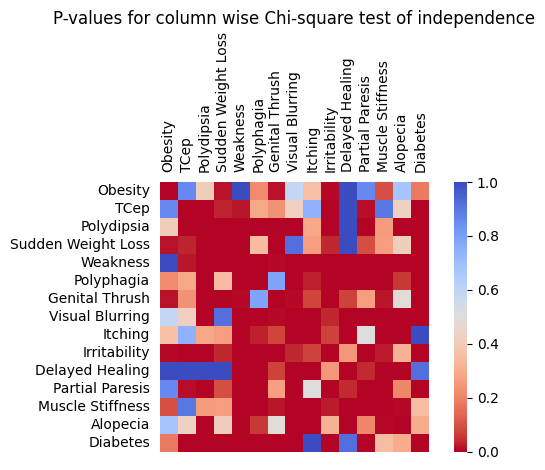

In [32]:
import matplotlib
from helpers import plot_chi_square_p_values

# reverse color as low p-value indicates strong dependence
plot_chi_square_p_values(train[binary_features + ['Diabetes']], kwargs={'cmap' : matplotlib.colormaps[cmap +'_r']}, outfile = 'images/cat_cat_corr.png')


Common sense can replace domain experts, in some cases - Roxana Pop, i.e. we should not use 'TCep' for our analysis (even though delayed healing might be correlated with aversion for tattoos)


In [33]:
from biseral_correlation import plot_point_biserial_correlation

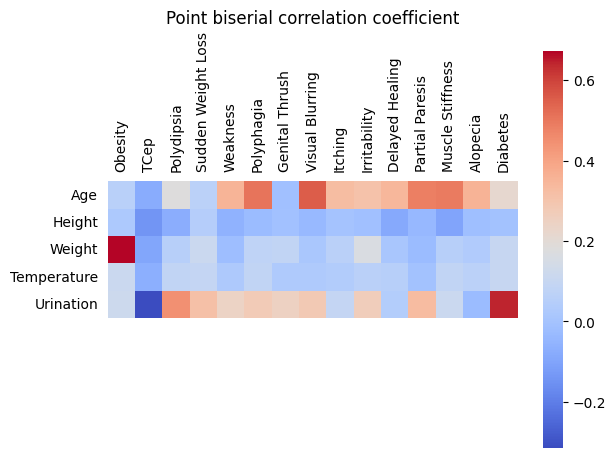

In [34]:
plot_point_biserial_correlation(train, cont=num_features, cat=binary_features + ['Diabetes'], kwargs={'cmap' : cmap}, outfile='images/cont_cat_corr.png')

In [35]:
from helpers import BMI

train['BMI'] = BMI(train['Weight'],  train['Height'])
test['BMI'] = BMI(test['Weight'],  test['Height'])

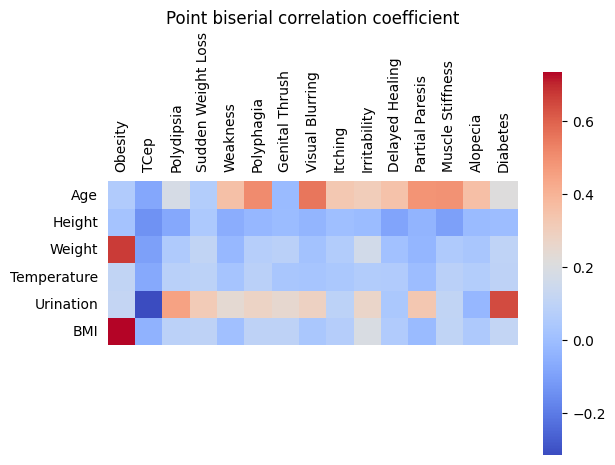

In [36]:
plot_point_biserial_correlation(train, cont=num_features + ['BMI'], cat=binary_features + ['Diabetes'], kwargs={'cmap' : cmap}, outfile = 'images/cont_cat_corr_bmi.png')

 We see that weight and obesity is strongly correlated, however BMI and obesity is not. Furthermore, diabetes has no correlation with either of them. This does not mean that BMI or weight are bad predictors, since the relationship between them could be non-linear. 

 Urination is indeed very correlated, which is apparent in the later plots.

## Data exploration

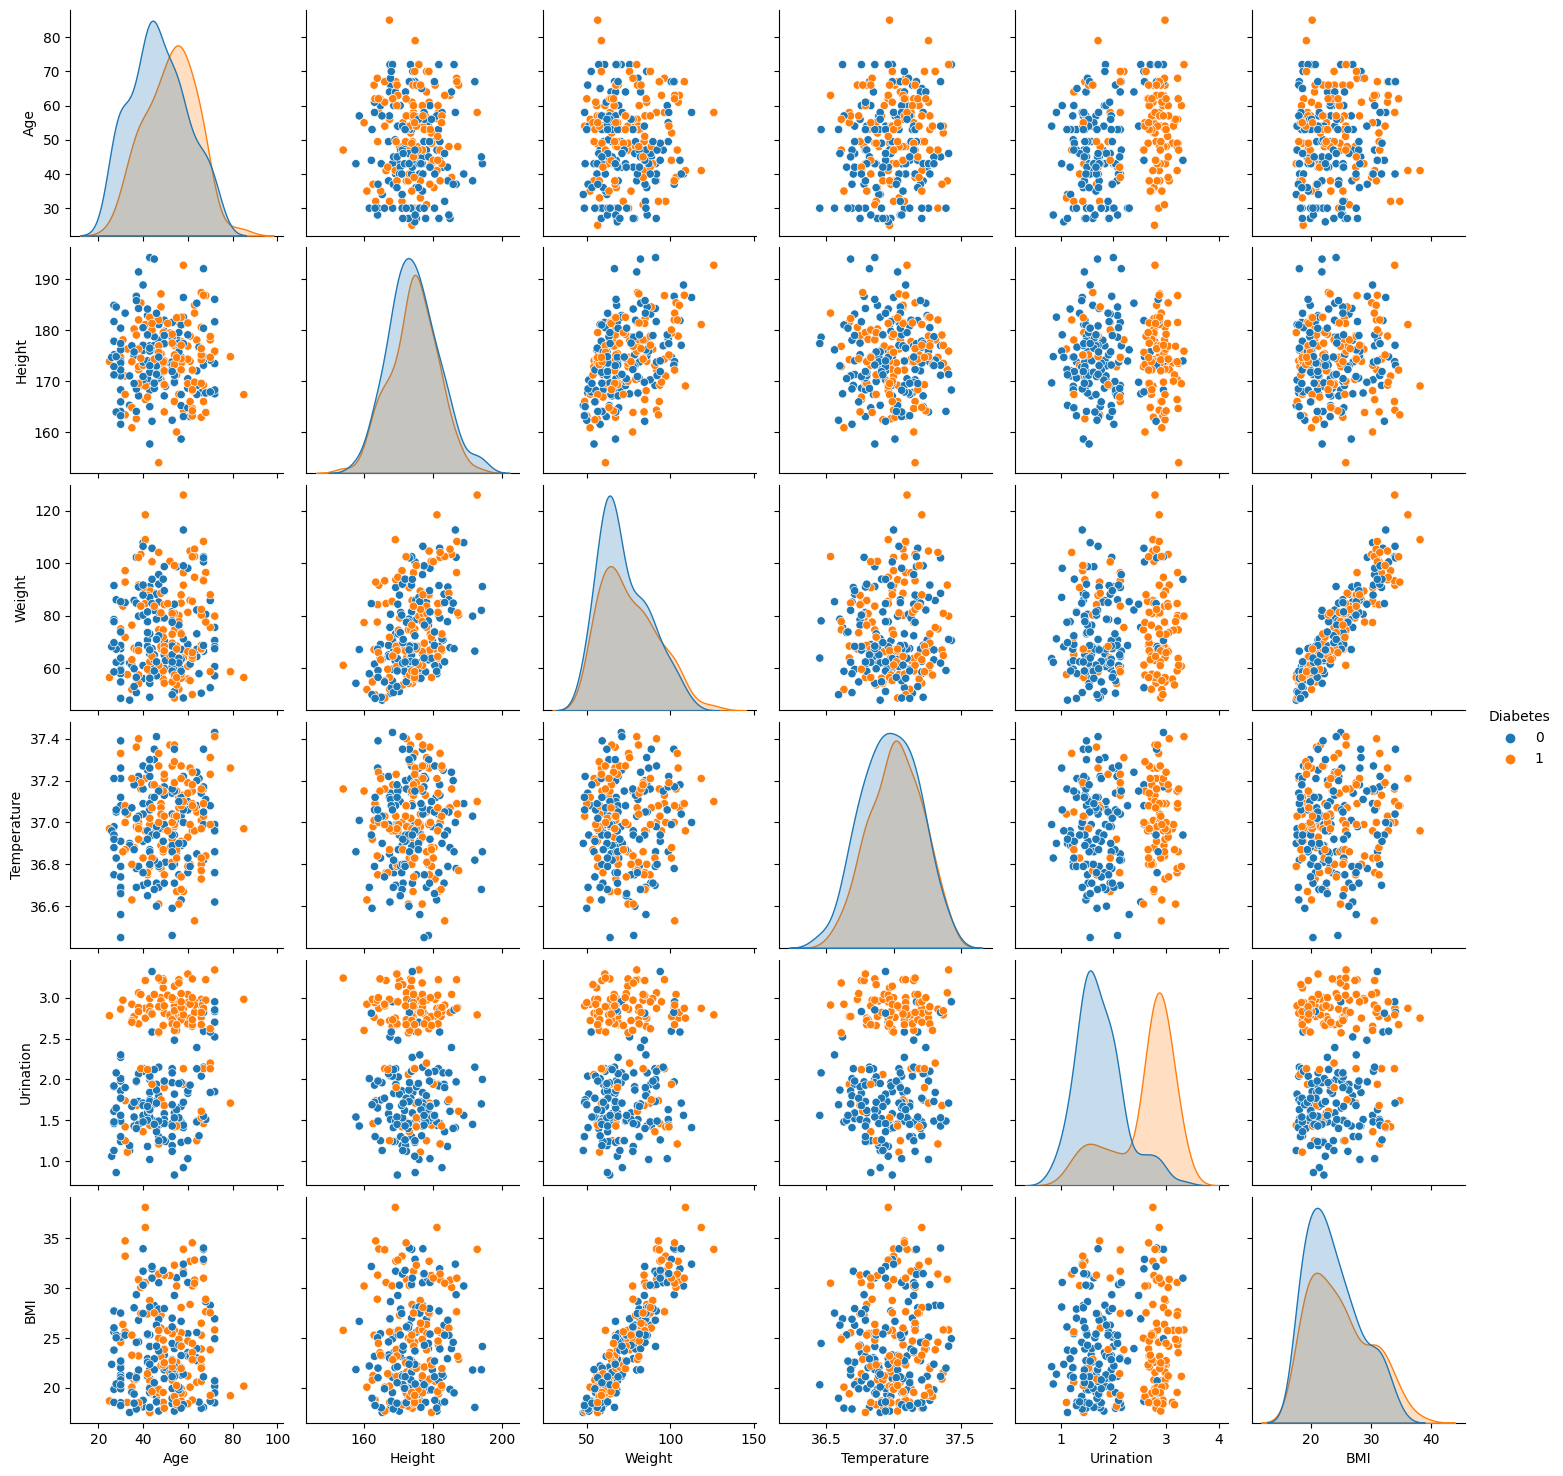

In [37]:

train_plot = train[num_features + ['BMI', 'Diabetes']]

#diabetes_plot = train.drop('Gender', axis=1)
g = sns.pairplot(train_plot, hue='Diabetes')

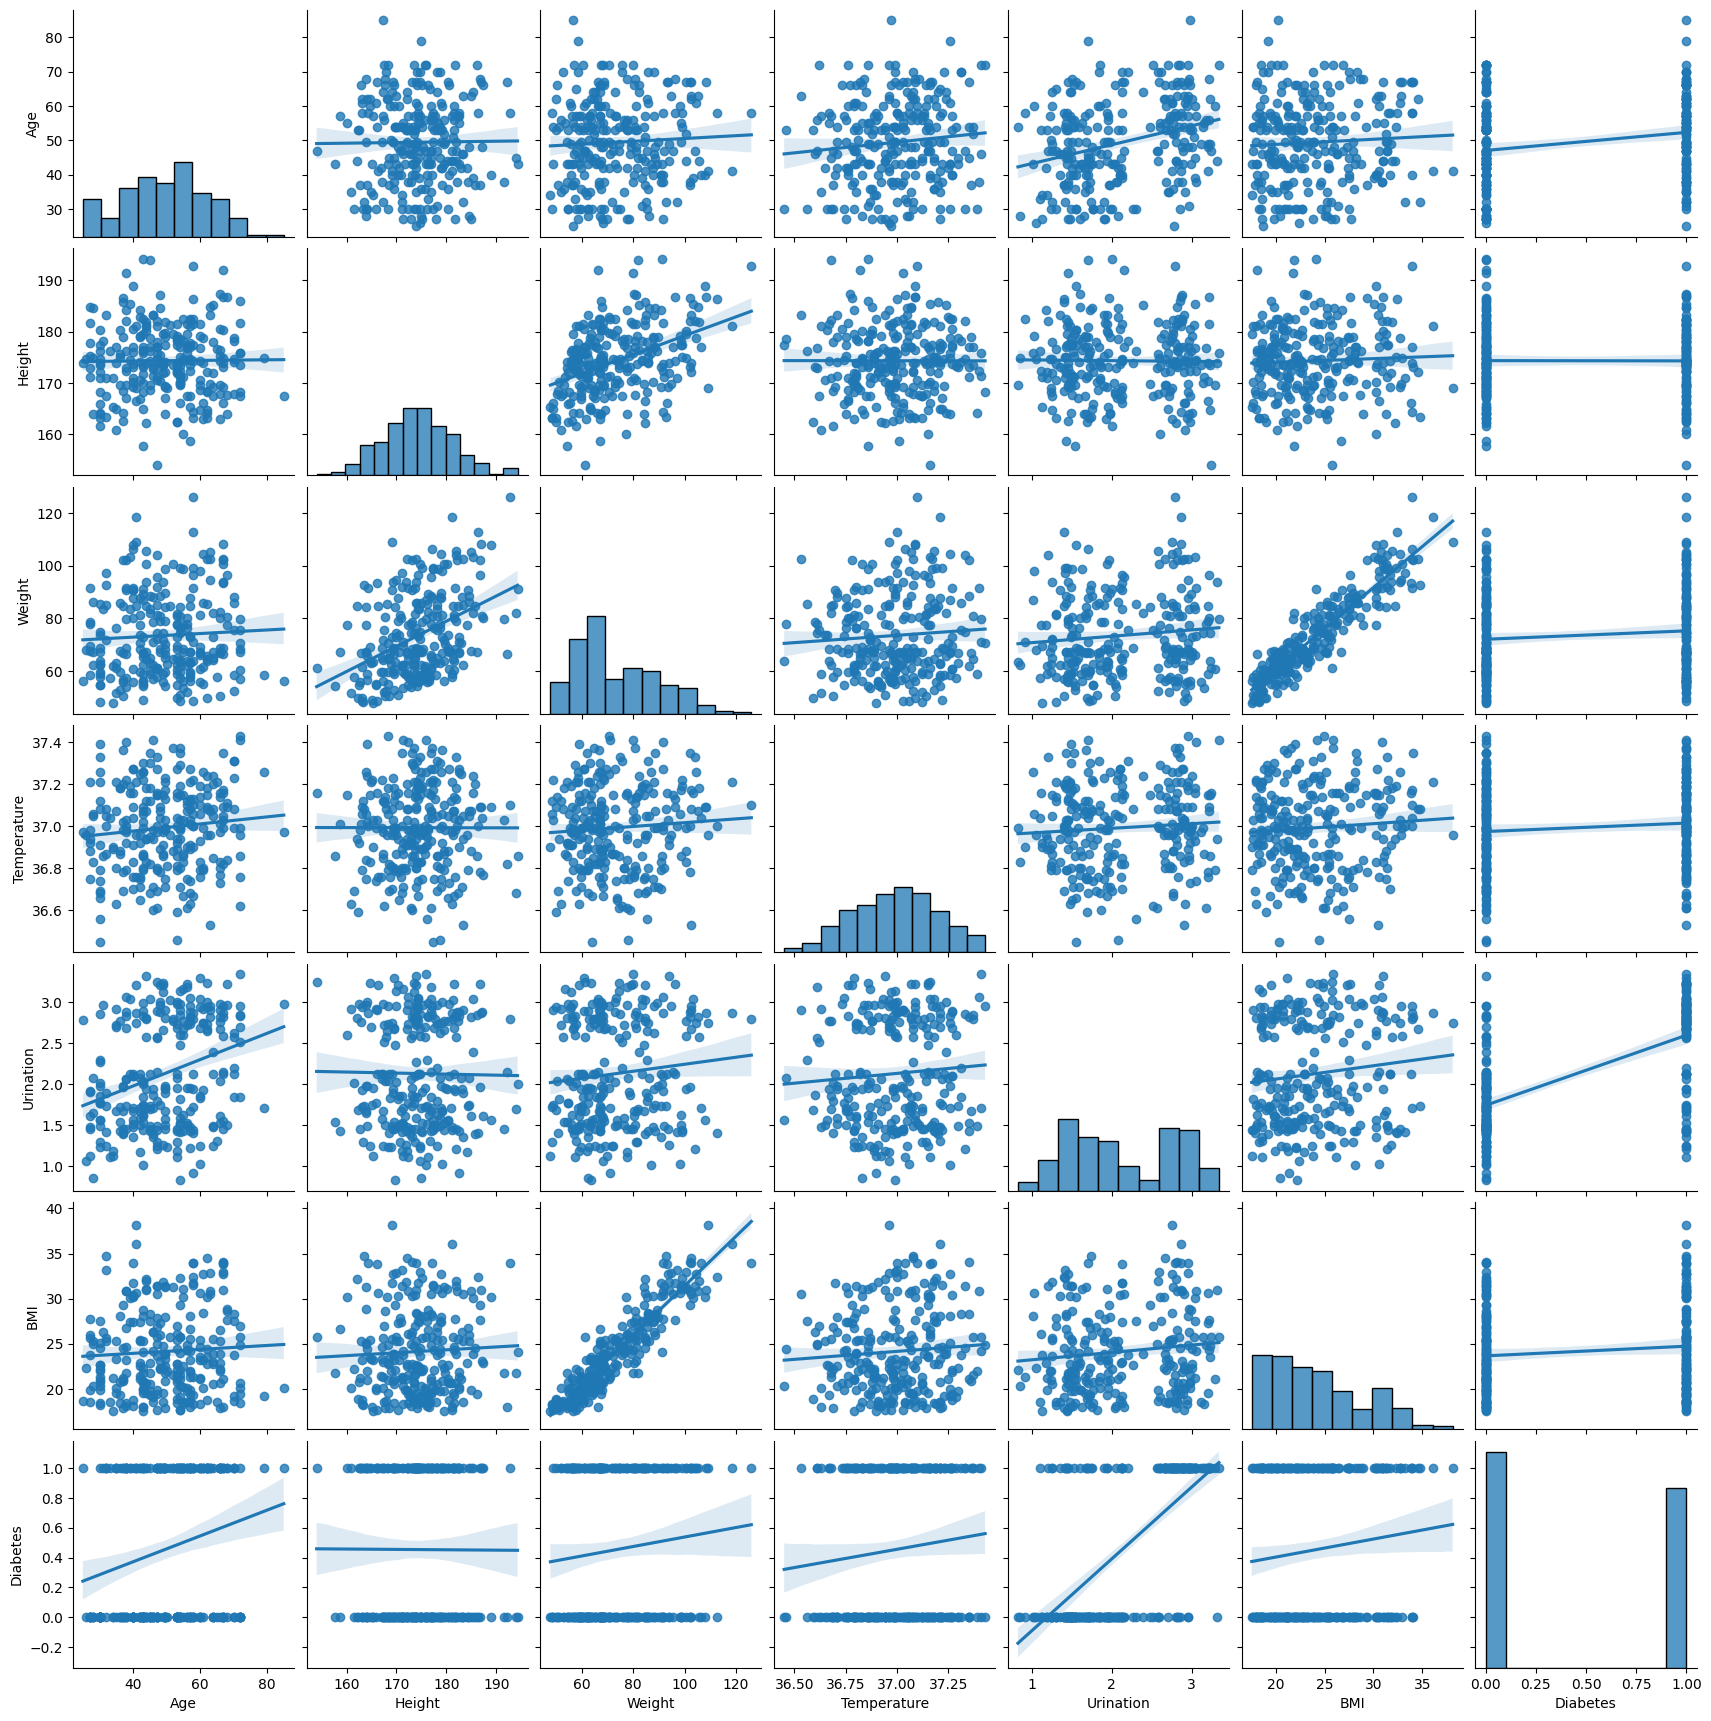

In [38]:
g = sns.pairplot(train_plot, kind='reg')

In [39]:
print(train.columns)

Index(['Age', 'Gender', 'Race', 'Occupation', 'GP', 'Height', 'Weight',
       'Obesity', 'Temperature', 'Urination', 'TCep', 'Polydipsia',
       'Sudden Weight Loss', 'Weakness', 'Polyphagia', 'Genital Thrush',
       'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing',
       'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'Diabetes',
       'gender_Male', 'BMI'],
      dtype='object')


# 3. Feature Selection

In [40]:
# Some sanity checks
assert train.isna().sum().sum() == 0, 'No Na-s should be present after handling. They must have been introduced'

#selected_features = ['Urination', 'Age'] + binary_features
selected_features = num_features + binary_features + one_hot_features['Gender'] +['BMI',]
selected_features.remove('Urination')
selected_features.remove('Obesity')
selected_features.remove('TCep')

print(selected_features)
print(len(selected_features))

['Age', 'Height', 'Weight', 'Temperature', 'Polydipsia', 'Sudden Weight Loss', 'Weakness', 'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'gender_Male', 'BMI']
18


## Training model

In [41]:
X_train = train[selected_features]
y_train = train['Diabetes']

# Test set
X_test = test[selected_features]
y_test = test['Diabetes']


for index in X_train.dtypes.keys():
    dtype = X_train.dtypes[index]
    print(index, dtype)
    # Quite ugly and not very felxible test. Should be improved upon
    assert dtype == 'float64' or dtype == 'int64' or dtype == 'uint8', f"feature '{index}' is not of type float or int but {dtype}"


Age float64
Height float64
Weight float64
Temperature float64
Polydipsia float64
Sudden Weight Loss float64
Weakness float64
Polyphagia float64
Genital Thrush float64
Visual Blurring float64
Itching float64
Irritability float64
Delayed Healing float64
Partial Paresis float64
Muscle Stiffness float64
Alopecia float64
gender_Male uint8
BMI float64


## Select k best

In [42]:
from sklearn.feature_selection import SelectKBest, chi2
skb =  SelectKBest(chi2, k='all')
X_new = skb.fit_transform(X_train, y_train)

cols_idxs = skb.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]

skb_dict={}

# what are scores for the features
for i in range(len(skb.scores_)):
    skb_dict[X_train.columns[i]] = skb.scores_[i]
    #print(X_train.columns[i], ":", skb.scores_[i])
# plot the scores
#features_df_new

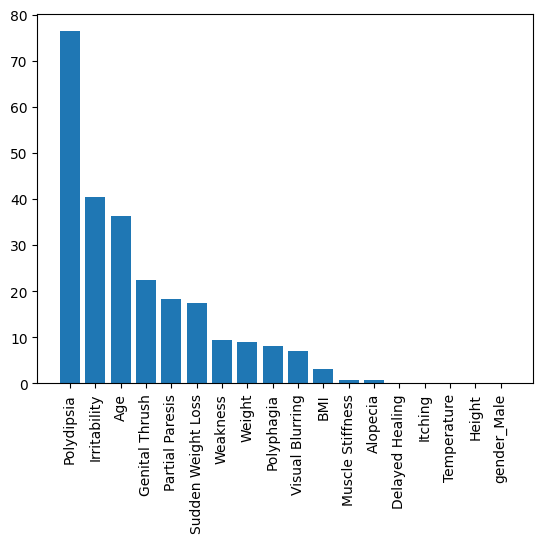

In [43]:
def plot_sorted_dict(d):
    d = sorted(d.items(), key=lambda x:-x[1])
    n = [i[0] for i in d]
    v = [i[1] for i in d]
    plt.bar(n, v)
    plt.xticks(rotation = 90)

plot_sorted_dict(skb_dict)

# 4. Classifier

## Baseline classifier
A simple Naive Bayes classifier to witch we compare our results. (ours are barely better)

In [44]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pass

## Decision Tree

Decision tree with depth=1. cv score: 0.823076923076923
Decision tree with depth=2. cv score: 0.8653846153846153
Decision tree with depth=3. cv score: 0.876923076923077
Decision tree with depth=4. cv score: 0.876923076923077
Decision tree with depth=5. cv score: 0.8769230769230768
Decision tree with depth=6. cv score: 0.8384615384615385
Decision tree with depth=7. cv score: 0.846153846153846
Decision tree with depth=8. cv score: 0.8615384615384615
Decision tree with depth=9. cv score: 0.8576923076923076
Decision tree with depth=10. cv score: 0.85
Decision tree with depth=11. cv score: 0.8615384615384615
Decision tree with depth=12. cv score: 0.8538461538461538
Decision tree with depth=13. cv score: 0.8461538461538461
Decision tree with depth=14. cv score: 0.8384615384615385
Decision tree with depth=15. cv score: 0.85
Decision tree with depth=16. cv score: 0.85
Decision tree with depth=17. cv score: 0.8384615384615385
Decision tree with depth=18. cv score: 0.8615384615384615
Decision tr

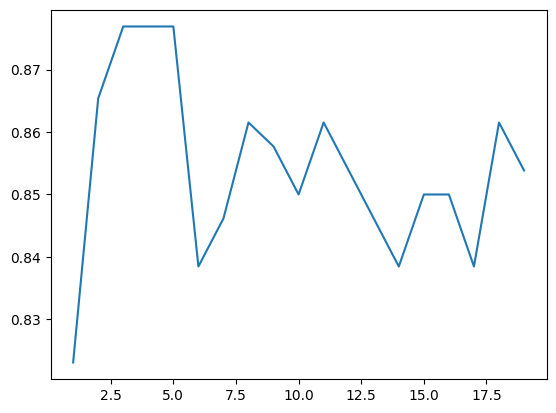

In [45]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depths = list(range(1, 20))

scores = {}

"""
By weighing misslcassification more severly, we can minimze type II error,
which is desirable in the public health scenario. However, even with
a very skewed weighing (1-100), we still get missclassification,
indicatting that there are 'outliers' in the test set.

Further investigation revealed that they typically where quite old or quite young,
with a typical amount of urination.
"""
weight = {0: 1,
          1:2}

use_weights = False

for d in depths:
    clf_cv = tree.DecisionTreeClassifier(max_depth=d, class_weight=weight if use_weights else None)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Decision tree with depth={d}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())

clf = tree.DecisionTreeClassifier(max_depth=7, class_weight=weight if use_weights else None)
clf_full_tree = clf.fit(X_train, y_train)

In [64]:
import graphviz

dot_data = tree.export_graphviz(clf_full_tree, out_file=None,
                      feature_names=selected_features,
                      class_names= ['Positive', 'Negative'], # this parameter doesen't seem to work
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
# Make Pdf
#graph.render("Diabetes")
graph

In [47]:
# Training accuracy
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix, precision_recall_fscore_support
#y_train_pred = clf.predict(X_train)
#metrics.accuracy_score(y_train, y_train_pred)

In [48]:
y_test_pred = clf_full_tree.predict(X_test)
#metrics.accuracy_score(y_test, y_test_pred)

In [49]:
from helpers import model_summary


In [50]:
model_summary(clf_full_tree, X_test, y_test, name='Full Tree')
model_summary(gnb, X_test, y_test, header=False, name='Naive Bayes')


Accuracy	Precision	Recall
0.86		0.91		0.74	Full Tree
0.82		0.76		0.81	Naive Bayes


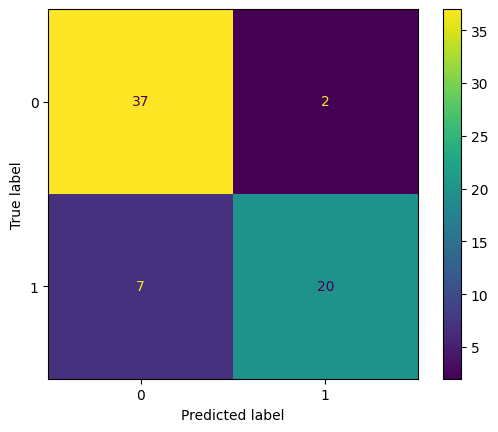

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()

In [52]:
X_test_plot = X_test.copy()
X_test_plot['error'] = y_test > y_test_pred
#g = sns.pairplot(X_test_plot.drop(binary_features, axis=1), hue='error')

### Some Pruning

Code borrowed from https://www.kaggle.com/code/arunmohan003/pruning-decision-trees-tutorial

In [53]:
path = clf_full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf_tmp = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, class_weight=weight if use_weights else None)
    clf_tmp.fit(X_train, y_train)
    clfs.append(clf_tmp)

[0.         0.00039235 0.00377984 0.00379791 0.004662   0.00486629
 0.00512821 0.00671256 0.00699301 0.00703933 0.00769231 0.01075847
 0.01109467 0.0247669  0.02591708 0.06892595 0.21512026]


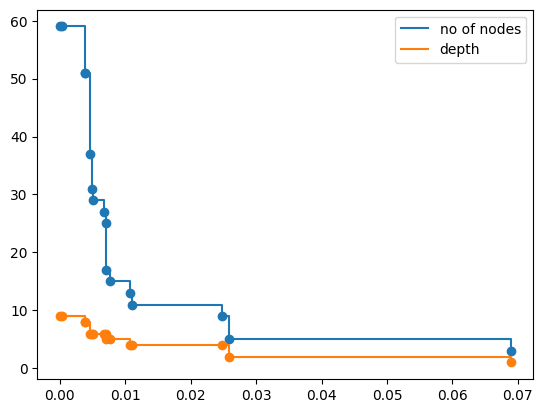

In [54]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import accuracy_score,confusion_matrix
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


In [56]:
alpha = 0.02
classes = ['Negative', 'Positive']
clf_pruned_tree = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=alpha,class_weight=weight if use_weights else None)
clf_pruned_tree.fit(X_train,y_train)
y_train_pred = clf_pruned_tree.predict(X_train)
y_test_pred = clf_pruned_tree.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')


Train score 0.9192307692307692
Test score 0.8636363636363636


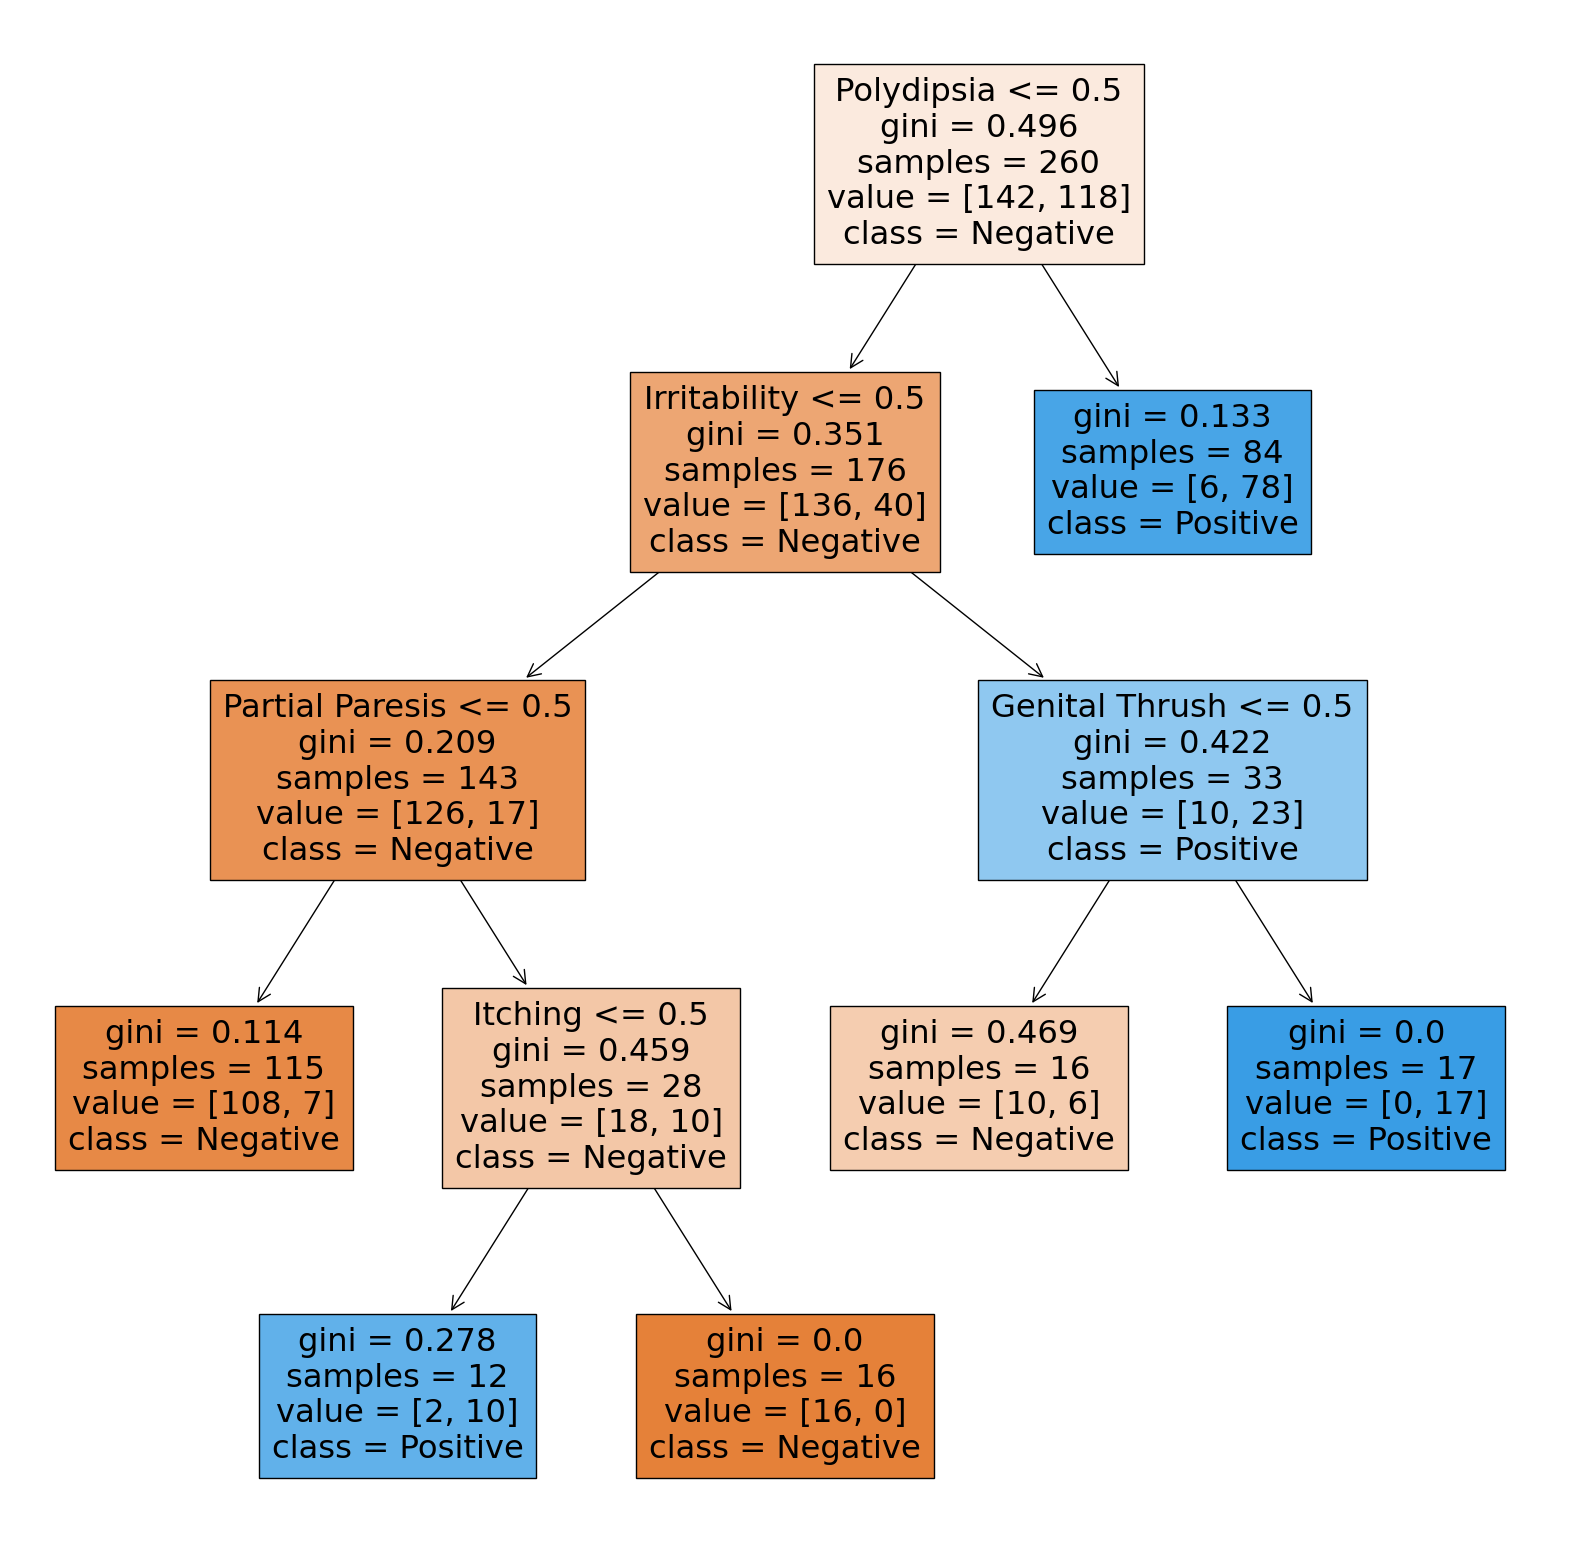

In [57]:
plt.figure(figsize=(20,20))
features = selected_features
tree.plot_tree(clf_pruned_tree,feature_names=features,class_names=classes,filled=True)
plt.show()

In [58]:
model_summary(clf_full_tree, X_test, y_test, name='Full Tree')
model_summary(clf_pruned_tree, X_test, y_test, header=False, name='Pruned Tree')
model_summary(gnb, X_test, y_test, header=False, name='Naive Bayes')


Accuracy	Precision	Recall
0.86		0.91		0.74	Full Tree
0.86		0.88		0.78	Pruned Tree
0.82		0.76		0.81	Naive Bayes


## Logistic Regression

Logistic regression with C = 10.00. cv score: 0.8692307692307691
Logistic regression with C = 7.85. cv score: 0.8692307692307694
Logistic regression with C = 6.16. cv score: 0.873076923076923
Logistic regression with C = 4.83. cv score: 0.876923076923077
Logistic regression with C = 3.79. cv score: 0.873076923076923
Logistic regression with C = 2.98. cv score: 0.8692307692307691
Logistic regression with C = 2.34. cv score: 0.8653846153846153
Logistic regression with C = 1.83. cv score: 0.8653846153846153
Logistic regression with C = 1.44. cv score: 0.8538461538461538
Logistic regression with C = 1.13. cv score: 0.85
Logistic regression with C = 0.89. cv score: 0.8461538461538461
Logistic regression with C = 0.70. cv score: 0.8461538461538461
Logistic regression with C = 0.55. cv score: 0.8461538461538461
Logistic regression with C = 0.43. cv score: 0.85
Logistic regression with C = 0.34. cv score: 0.85
Logistic regression with C = 0.26. cv score: 0.8461538461538461
Logistic regression 

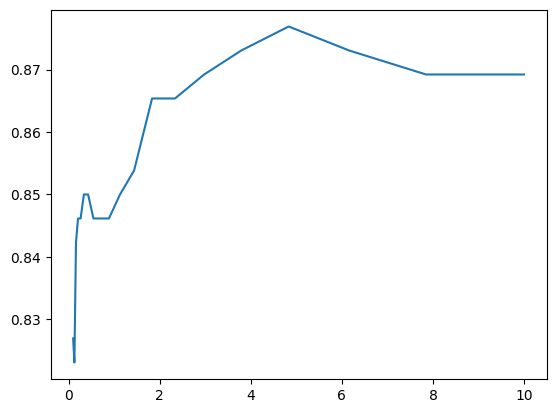

0.8181818181818182
[[-4.12627694e-02 -1.39843626e-02  6.13804464e-02  2.53182907e-01
   5.16503501e+00  5.06806954e-01  5.18336510e-01 -9.44899129e-04
   2.35835943e+00  6.89323490e-01 -2.12554893e+00  3.41512091e+00
  -6.78171459e-01  2.25246908e+00  3.68815883e-01  1.03296686e+00
  -3.79733114e+00 -2.35418461e-01]]


c:\custom programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


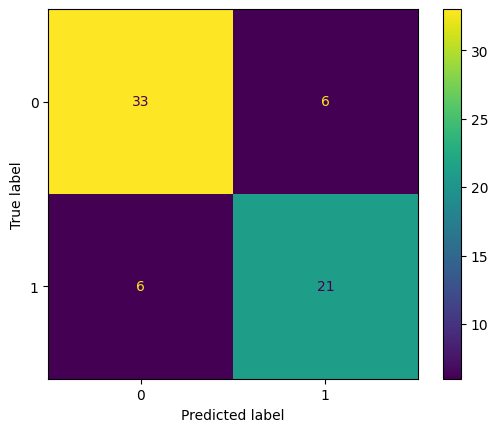

In [59]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty='l1', solver='liblinear', C=1000)

cs = 1/np.geomspace(0.1, 10, 20)

scores = {}


for c in cs:
    clf_cv = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[c] = score
    print(f'Logistic regression with C = {c:.2f}. cv score: {score}')

plt.plot(scores.keys(), scores.values())
plt.show()


clf_lr.fit(X_train, y_train)

y_test_pred = clf_lr.predict(X_test)

# Accuracy
print(metrics.accuracy_score(y_test, y_test_pred))
print(clf_lr.coef_)

# Confusion Matrix
confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()


In [60]:
metrics.accuracy_score(y_test, y_test_pred)

0.8181818181818182

In [61]:
model_summary(clf_full_tree, X_test, y_test, name='Full Tree')
model_summary(clf_pruned_tree, X_test, y_test, header=False, name='Pruned Tree')
model_summary(clf_lr, X_test, y_test, header=False, name='Logistic Regression')
model_summary(gnb, X_test, y_test, header=False, name='Naive Bayes')

Accuracy	Precision	Recall
0.86		0.91		0.74	Full Tree
0.86		0.88		0.78	Pruned Tree
0.82		0.78		0.78	Logistic Regression
0.82		0.76		0.81	Naive Bayes


In [62]:
from sklearn.ensemble import AdaBoostClassifier

clf_boost = AdaBoostClassifier(n_estimators=10000, random_state=0, learning_rate = 0.01)
clf_boost.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=10000, random_state=0)

In [63]:
model_summary(clf_full_tree, X_test, y_test, name='Full Tree')
model_summary(clf_pruned_tree, X_test, y_test, header=False, name='Pruned Tree')
model_summary(clf_lr, X_test, y_test, header=False, name='Logistic Regression')
model_summary(clf_boost, X_test, y_test, header=False, name='Ada Boost')
model_summary(gnb, X_test, y_test, header=False, name='Naive Bayes')

Accuracy	Precision	Recall
0.86		0.91		0.74	Full Tree
0.86		0.88		0.78	Pruned Tree
0.82		0.78		0.78	Logistic Regression
0.85		0.81		0.81	Ada Boost
0.82		0.76		0.81	Naive Bayes
